# Mask Workflow Example

To check the outputs for this notebook, view the [Github documentation](https://github.com/GeodataTools/geodata/blob/master/doc/mask/mask_creation_workflow.md).

## 1. Introduction

Geodata is able to process geospatial data to extract cutouts over specified geographies. Built off the [rasterio library](https://rasterio.readthedocs.io/en/latest/quickstart.html), the **mask** module imports rasters and shapefiles, merges and flattens multiple layers together, and extracts subsetted cutout data from merged masks and shapefiles.

Functionalities explored in this notebook:

- Creating a mask object, adding and manipulating layers
- Opening a shapefile and adding shape features as layers
- Merging and flattening layers
- Eliminate small contiguous areas
- Extracting shapes from mask
- Saving and loading masks

## 2. Setup

To start, import the geodata package and required libraries. We can also import the `geodata.mask.show()` method for simplicity of its use.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import geodata
from geodata.mask import show

To launch a logger for detailed debugging, run:

In [2]:
import logging

logging.basicConfig(level=logging.INFO)

We use [cartopy](https://scitools.org.uk/cartopy/docs/latest/tutorials/using_the_shapereader.html#cartopy.io.shapereader.Reader) to download some common administrative region shapes, but user-provided shapefiles will also work:

In [3]:
import cartopy.io.shapereader as shpreader

We will use the following geotiff and shape files for this demo:


#### china_modis.tif

We downloaded the MODIS land cover data, which uses satellite remote sensing data to estimate the land use type on an annual basis. See: [EarthData_MCD12Q1](https://lpdaac.usgs.gov/products/mcd12q1v006/).

We will use the IGBP classification ('LC_Type1') which has 17 different land use characterizations (the corresponding data thus takes values from 1.0 to 17.0).
All the "Bands" are listed here: [Google_earth_engine_MODIS_006_MCD12Q1](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1#bands)

#### china_elevation.tif & china_slope.tif

These two rasters are based on the elevation map from: [Google_earth_engine_MODIS_CGIAR_SRTM90_V4](https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4?hl=en). Slope was computed in degrees using the 4-connected neighbors of each pixel. 


#### UNEP_WDPA_China shapefiles

We downloaded the environmental protected area for China from: [ProtectedPlanet_China](https://www.protectedplanet.net/country/CHN). These shapefiles are distributed among 3 subfolders upon successful download and decompression due to the large size. We will create path variables for all three subfolders and we will only take the polygon shapes.

Alternatively, We can also retrieve the environmental protected area from Google Earth Engine: [Google_earth_engine_WCMC_WDPA](https://developers.google.com/earth-engine/datasets/catalog/WCMC_WDPA_current_polygons). The shapefile will contain the protected shapes from entire world (and the size is slightly over 1 GB), and additional data cleaning will be necessary if the user wants just the shapes within China. 



In [4]:
modis_path = "data/china_modis.tif"
elevation_path = "data/china_elevation.tif"
slope_path = "data/china_slope.tif"

wdpa_shape_path_0 = "data/shapefiles/0/WDPA_WDOECM_Nov2021_Public_CHN_shp-polygons.shp"
wdpa_shape_path_1 = "data/shapefiles/1/WDPA_WDOECM_Nov2021_Public_CHN_shp-polygons.shp"
wdpa_shape_path_2 = "data/shapefiles/2/WDPA_WDOECM_Nov2021_Public_CHN_shp-polygons.shp"

Let us get province shapes from `cartopy` and save the path as `prov_path`. This can also be the path to user-supplied shape files.

In [ ]:
prov_path = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_1_states_provinces"
)
prov_path

Load the shapes contained in path `prov_path` using the `geopandas` library.

In [6]:
all_shapes = gpd.read_file(prov_path, encoding="utf-8")
all_shapes.head(2)

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 states provinces,3,ARG-1309,1309,AR-E,NaN,AR,1,Entre Ríos,Entre-Rios,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4..."
1,Admin-1 states provinces,6,URY-8,8,UY-PA,NaN,UY,1,Paysandú,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-58.20012 -32.44720, -58.20011 -32.4..."


Geopandas data filtering with geodataframe is identical to pandas. Let us select all the rows that contains a Chinese shape. 

In [7]:
china_shapes = all_shapes[all_shapes["admin"] == "China"]

Next, to load the WDPA environmental protected shapefiles as a layer in the china mask, we will use the GeoPandas library. `gpd.read_file()` will return a GeoPandas dataframe including shape attributes and geometry given the file path. Like Pandas, we can read multiple dataframes and concat them together. In the code below, we will create one GeoPandas dataframe from three paths that we have for the Chinese environmental protected shapes.

In [8]:
wdpa_shapes = pd.concat([
    gpd.read_file(wdpa_shape_path_0),
    gpd.read_file(wdpa_shape_path_1),
    gpd.read_file(wdpa_shape_path_2)
])
wdpa_shapes.head(2)

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,SUPP_INFO,CONS_OBJ,geometry
0,3014.0,3014,1,Changbaishan,Changbaishan,UNESCO-MAB Biosphere Reserve,UNESCO-MAB Biosphere Reserve,International,Not Applicable,Not Applicable,...,Not Reported,Not Reported,Not Reported,526,CN-22,CHN,CHN,Not Applicable,Not Applicable,"POLYGON ((128.07660 42.42638, 128.09174 42.425..."
1,3015.0,3015,1,Wolong Nature Reserve,Wolong Nature Reserve,UNESCO-MAB Biosphere Reserve,UNESCO-MAB Biosphere Reserve,International,Not Applicable,Not Applicable,...,Not Reported,Not Reported,Not Reported,526,CN-51,CHN,CHN,Not Applicable,Not Applicable,"POLYGON ((103.16235 31.32249, 103.17282 31.311..."


## 3. Creating mask object, adding and manipulating layers

The mask object consists of multiple layers and manipulations performed on them. To add a layer, the four methods below perform same functions. A user may add a layer to the mask by specifying paths when a new instance is created, or use the `add_layer` method. We will add the following two files: `china_elevation.tif`, and `china_modis.tif` to the `China` mask, and name them `elevation` and `modis` layers.

In [9]:
# Method 1: Initialize one layer, add one layer
china = geodata.Mask("China", layer_path=elevation_path)
china.rename_layer("china_elevation", "elevation")
china.add_layer(modis_path, layer_name="modis")

INFO:geodata.mask:Layer china_elevation added to the mask China.
INFO:geodata.mask:Raster data/china_modis.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


In [10]:
# Method 2:  Initialize empty, add two layers using dict
china = geodata.Mask("China")
china.add_layer(layer_path={"elevation": elevation_path, "modis": modis_path})

INFO:geodata.mask:Layer elevation added to the mask China.
INFO:geodata.mask:Raster data/china_modis.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


In [11]:
# Method 3:  Initalize with two layers passed as list
china = geodata.Mask(
    "China", layer_path=[elevation_path, modis_path], layer_name=["elevation", "modis"]
)

INFO:geodata.mask:Layer elevation added to the mask China.
INFO:geodata.mask:Raster data/china_modis.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


In [12]:
# Method 4:  Initialize with two layers passed as dict
china = geodata.Mask(
    "China", layer_path={"elevation": elevation_path, "modis": modis_path}
)

INFO:geodata.mask:Layer elevation added to the mask China.
INFO:geodata.mask:Raster data/china_modis.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


Display the mask object in the jupyter notebook:

In [13]:
china

Mask China: 
2 layers: ['elevation', 'modis'].
No merged_mask ready. 
No shape has been extracted. 
Mask has not been saved/updated. 

Each mask object has several attributes:
- `layers`: a dictionary of name (key)  - rasterio file opener (values). The <\open DatasetReader> can be the input for many other mask methods for the module.  
- `merged_mask`: the merged and flatten mask of its layers, the merged raster from `layers`
- `shape_mask`: similar to the `layers` attribute, but a dictionary of extracted shapes from the merged mask by default. Users may also extracted shape masks from specified layers in `self.layers`.
- `saved`: whether this mask object has been saved locally.
- `mask_dir`: the directory to save the mask object, by default it should be the mask dir in config.py.

Show the `slope` layer in mask `china`. The `show` method will always try to show the proper latitude and longitude, unless we call it `show(layer, lat_lon = False)`.

In [14]:
china.layers["elevation"]

<open DatasetWriter name='data/china_elevation.tif' mode='r+'>

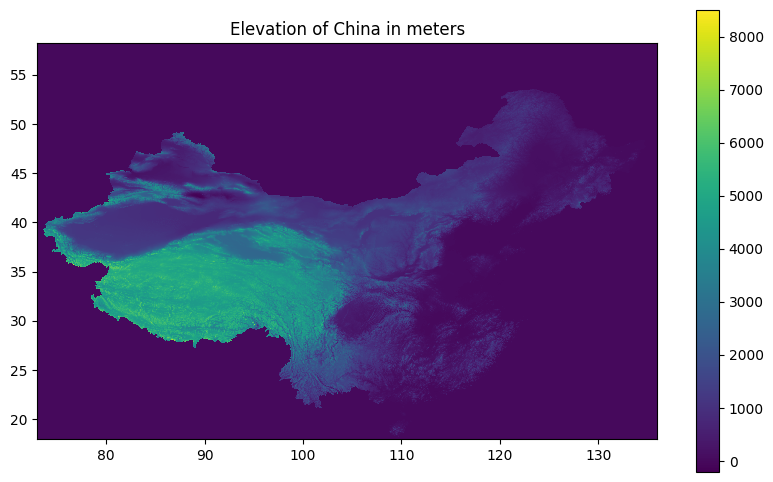

In [15]:
show(china.layers["elevation"], title="Elevation of China in meters")

In [16]:
china.layers

{'elevation': <open DatasetWriter name='data/china_elevation.tif' mode='r+'>,
 'modis': <open DatasetReader name='/vsimem/5be672ad-7808-4a90-a696-47a9588621ca/5be672ad-7808-4a90-a696-47a9588621ca.tif' mode='r'>}

**Some useful methods to examine the layers**

- `china.get_res()`: get resolution of each layer, in lat-lon coordinates
- `china.get_res(product = True)`: get grid cell size, in product of lat-lon coordinate differences
- `china.get_bounds()`: get bounds, in lat-lon coordinates

In [17]:
china.get_bounds()

{'elevation': BoundingBox(left=72.99253346658085, bottom=17.994777314571174, right=136.0003674947241, top=58.23031889028454),
 'modis': BoundingBox(left=45.06648525175075, bottom=18.09346454744204, right=179.98900785281631, top=58.38850413860287)}

Note that the modis layer has a very different bounding box then the slope layer in lat-lon coordinate system. This is because the modis layer was converted to the lat-lon CRS from a different CRS when it was added to the object. The following section will explore CRS conversion.

### 3.1 CRS conversion, trimming, and cropping (if necessary)

Method `open_tif` can open a layer without adding it to the layer, this allows us to visualize it before-hand. It is a good practice to close the raster after opening it to avoid writing permission conflict issues. Closing the raster below does not involve any layer operation associated with the mask object. 

INFO:geodata.mask:Please remember to close the file with .close()


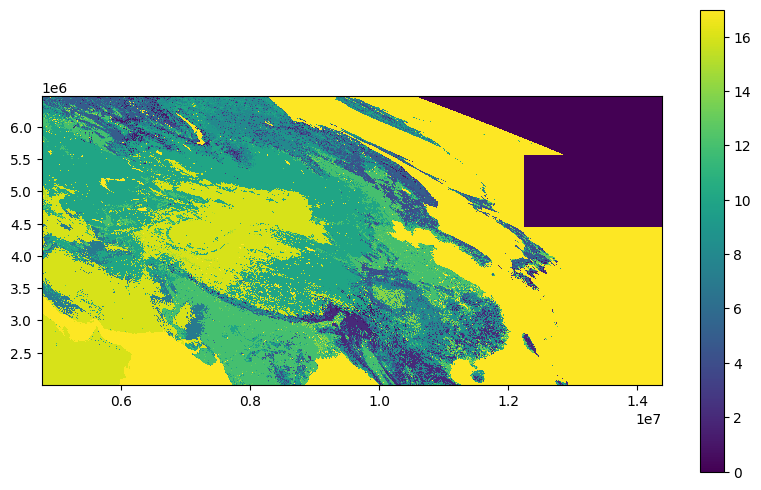

In [18]:
modis_opener = geodata.mask.open_tif(modis_path, show_raster=True)
modis_opener.close()

We can use `remove_layer` method to remove a layer to mask `china`. This method will properly close the raster file, because the raster file would remain open after being added to the mask.

In [19]:
china.remove_layer("modis")

The `add_layer` method incorporates coordinate reference system (CRS) conversion to lat-lon (EPSG:4326), if necessary. Note that this method will overwrite the layer by default, if it is in the object already, unless the user specifies `replace=False`. 

The method will automatically trim the all-zero columns/rows. By default, the paramater `trim` is set to `True`. If we do not set it to True, we might generate a converted raster with new CRS but many all-zero columns and rows.

INFO:geodata.mask:Raster data/china_modis.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


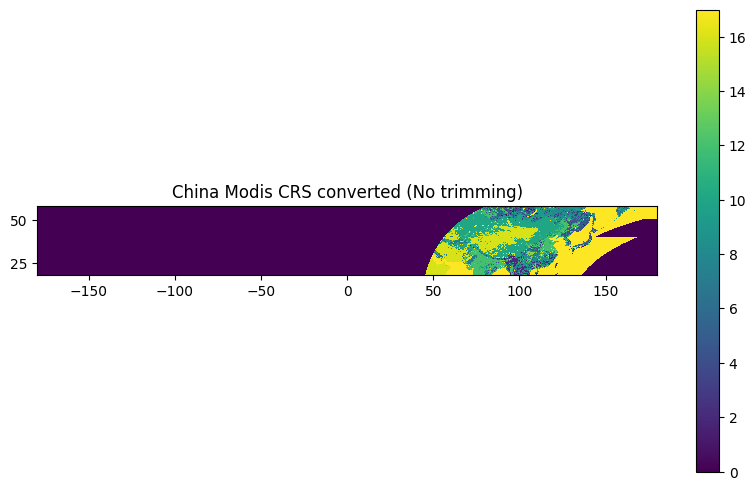

In [20]:
china.add_layer(modis_path, "modis", trim=False)
show(china.layers["modis"], title="China Modis CRS converted (No trimming)")

We can also crop a raster/layer with user-defined dimensions: method `crop_layer` can take either starting indices of top/left, ending indices of right/bottom, or coordinates values in lat/long to trim the raster.

The difference between `crop_layer` and `trim_layer` is that `crop_layer` must take in user specified range to crop the raster, and `trim_layer` would remove the all zero rows and columns automatically for a raster. So that if the user do not know which index to start and end to remove the empty rows/columns, `trim_raster` is better.

The method `crop_raster` (`geodata.mask.crop_raster`) is similar to `crop_layer` but can take a layer name as input, so that the user does not need to add a raster as a layer to call that method. (Similar method: `trim_layer`/`trim_raster`, `binarize_layer`/`binarize_raster`)

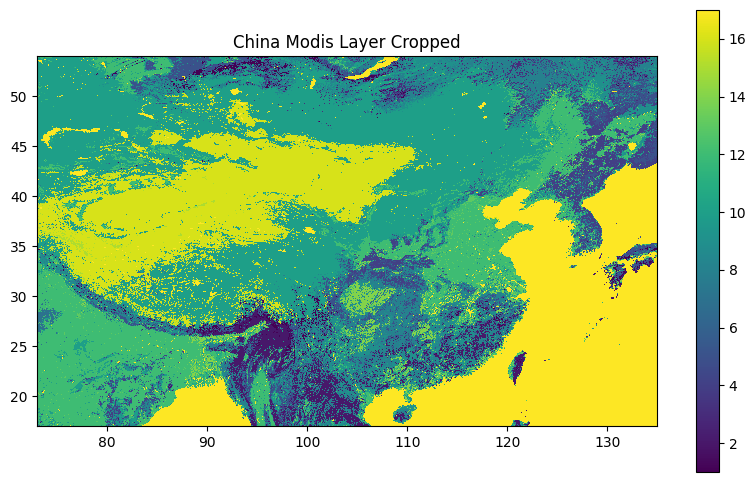

In [21]:
china.crop_layer("modis", bounds=(73, 17, 135, 54))
show(china.layers["modis"], title="China Modis Layer Cropped")

This performs the same function by passing the layer to `crop_raster`:

In [22]:
china.layers["modis"] = geodata.mask.crop_raster(
    china.layers["modis"], (73, 17, 135, 54)
)

### 3.2 Filter a layer

The mask module also supports filtering a layer based on list of categorical values, a minimum (lower) boundary, or maximum (upper) boundary.

In the `filter_raster` method, a user may specify any of the `value` (the list of numberic values in the raster array to be selected), `max_bound`, and `min_bound` parameters to selected desired values. If the parameter `binarize` is False (by default), the method will return the original values of the raster that satisfy the conditions, otherwise the method will return 1 for the values that satisfy the conditions and 0 elsewhere.

#### a). Select categorical values from modis layer

Since the modis layer has 17 distinct values for different land use types, we want to create a layer of binary values, indicating unavailable land as 0, and available land as 1.

We wish to create a mask where :

- all forested areas (values 1-5) are 0 (i.e., unsuitable)
- all urban areas (13) are 0
- all others are 1


Let us use method `filter_raster` to create a layer of `modis_filtered` binary mask, where 1, 2, 3, 4, 5, and 13 will be unavailable land assigned 0 and the rest of the values will be 1 (available).


In [23]:
avail_values = list(set(range(1, 18)) - set([1, 2, 3, 4, 5, 13]))
avail_values

[6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]

In [24]:
china.layers["modis_filtered"] = geodata.mask.filter_raster(
    china.layers["modis"], binarize=True, values=avail_values
)

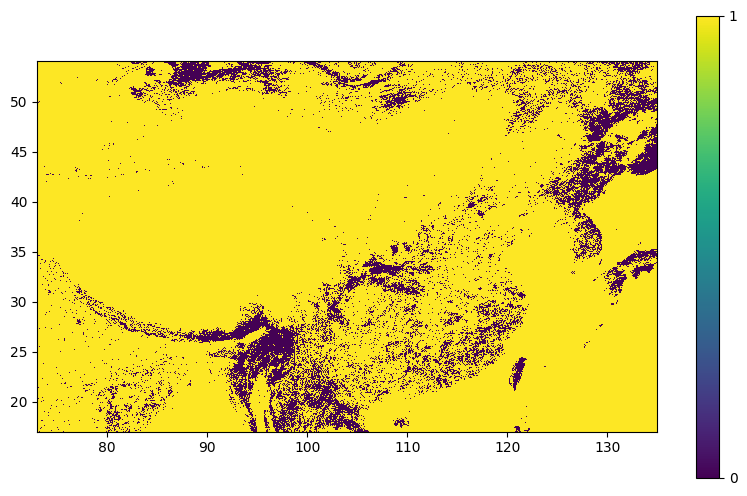

In [25]:
china.remove_layer("modis")
show(china.layers["modis_filtered"])

#### b). Filter elevation layer

Because we cannot build renewable energy in areas with high elevation, let us set the constraint from the `elevation` layer, by using elevation < 4000m at 1 and other areas as 0. The result layer `elevation_filtered` will have only 1 and 0 as unique values.

In [26]:
china.filter_layer(
    "elevation", dest_layer_name="elevation_filtered", max_bound=4000, binarize=True
)

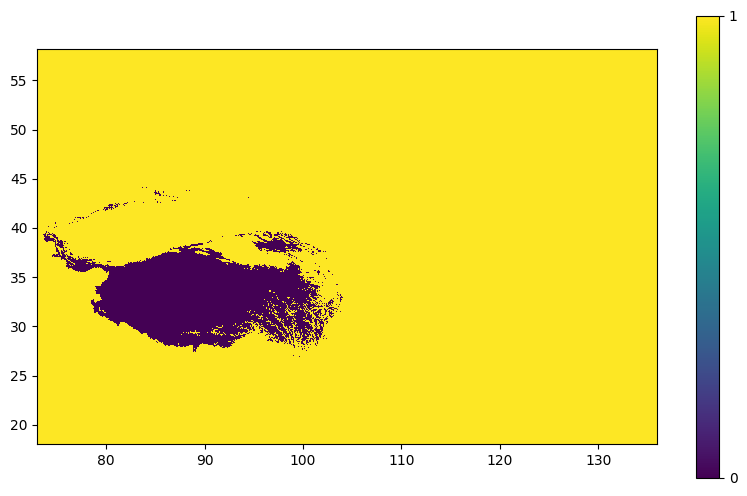

In [27]:
china.remove_layer("elevation")
show(china.layers["elevation_filtered"])

#### c). Filter slope layer

We also cannot build renewable energy in area with large slopes, so let us set another constraint from the `slope` layer from the slope tif file, by using slope < 20 degree at 1 and else as 0. The result layer `slope_filtered` will have only 1 and 0 as unique values.

</div>


First, add the slope raster to the china mask.

INFO:geodata.mask:Layer slope added to the mask China.


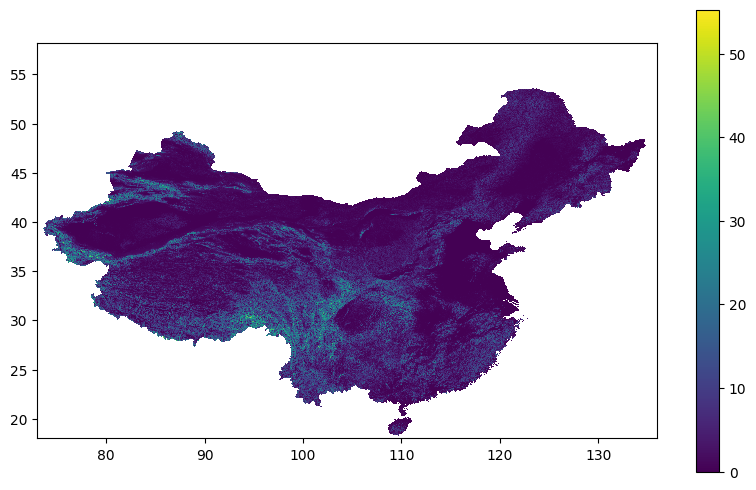

In [28]:
china.add_layer(slope_path, layer_name="slope")
show(china.layers["slope"])

Filter the raster, delete the old slope layer.

In [29]:
china.filter_layer(
    "slope", dest_layer_name="slope_filtered", max_bound=20, binarize=True
)

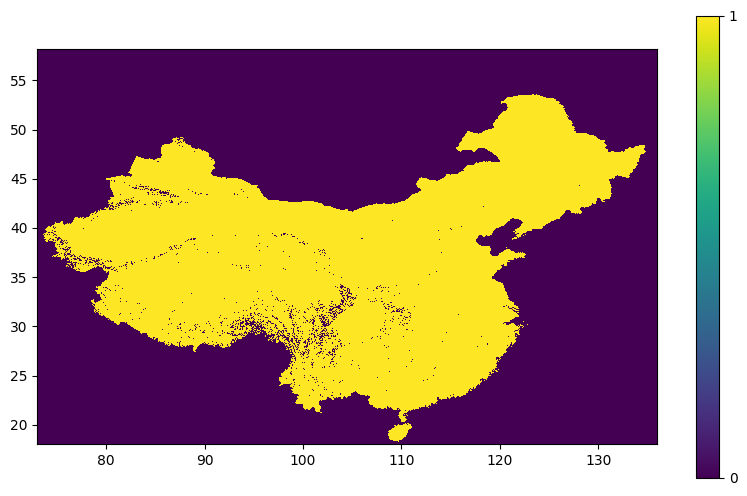

In [30]:
china.remove_layer("slope")
show(china.layers["slope_filtered"])

### 3.3 Additional show options

We can plot the provinces on a selected layer by taking `shape` input in the `show()` method. Here, we will use the `china_shapes` that we obtained from `all_shape`. Its `geometry` column is a Series of shapes (shapely.geometry or MultiPolygon) for Chinese provinces.

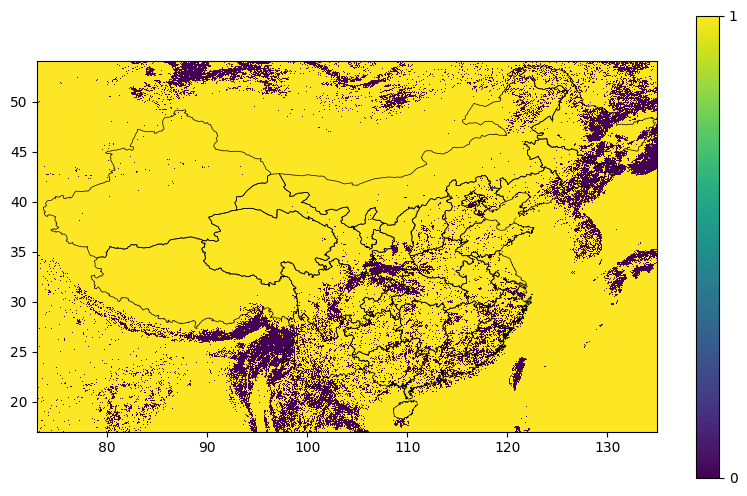

In [31]:
show(china.layers["modis_filtered"], shape=china_shapes["geometry"])

## 4. Opening a shapefile and adding shape features as a layer

Recall that we have previously loaded the environmental protected shapes of China in a GeoPandas dataframe.

In [32]:
len(wdpa_shapes)

78

The three shapefiles have 78 features altogether, but we want to add all the features to one new layer instead of 78 new layers. The input shape should be a python dictionary, where there is a key for each unique shape. Also, in the `add_shape_layer` method, we will specify a `combine_name` to combine the features into one layer in this case, since we want the mask to have just one more layers, not 78 more layers.

When adding a shapefile, we must specify the dimensions. We will also use `reference layer = 'slope_filtered'` so the new shape layer will have the same dimension with the `slope_filtered` layer. If the mask is empty and does not contain any layer, the user will have to specify the `resolution` parameter for the raster layer dimension.

By default, this method will have paramater `exclude` that defaults to `False`. When it is true, area inside the shape is 0. When it is false, area inside the shape is 1. In this use case, however, we want 0 for area inside of the shape as they are environmental protected areas to exclude. We can just use the default method call.

INFO:geodata.mask:Layer protected added to the mask China.


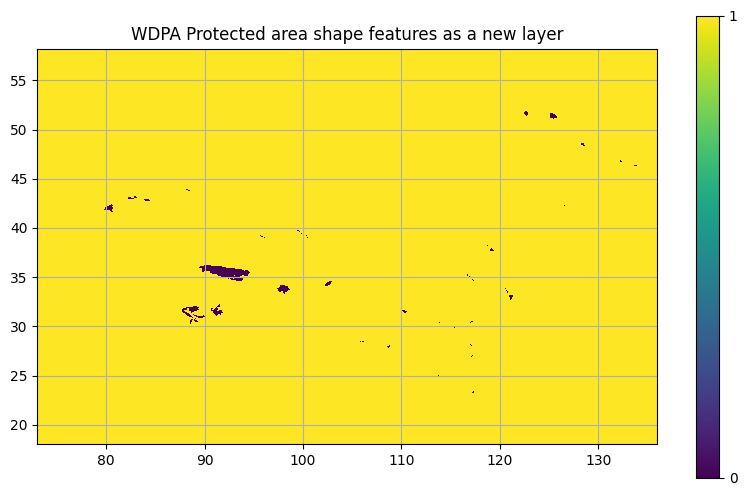

In [33]:
china.add_shape_layer(
    wdpa_shapes["geometry"].to_dict(),
    reference_layer="slope_filtered",
    combine_name="protected",
)
show(
    china.layers["protected"],
    title="WDPA Protected area shape features as a new layer",
    grid=True,
)

We can also use the parameter `buffer` in `add_shape_layer` method to create an approximate representation of all locations within a given (perpindicular) distance of the shape object. The units for the buffer are given in kilometers.

Note that since the units of the original shape are in lat-lon coordinates, when we add the buffer, we will need to have a CRS that has meter as unit. The program will convert the shapes to that CRS, add the buffer around shapes, then convert it back to the lat-lon CRS system. By default, we used "EPSG:6933", an equal area projection CRS to add buffer in kilometer. 

INFO:geodata.mask:Layer protected_with_buffer added to the mask China.


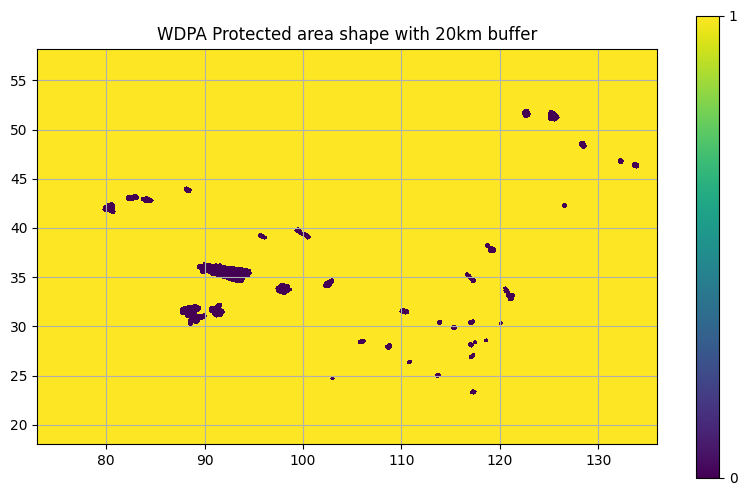

In [34]:
km_buffer = 20

china.add_shape_layer(
    wdpa_shapes["geometry"].to_dict(),
    reference_layer="slope_filtered",
    combine_name="protected_with_buffer",
    buffer=km_buffer,
)

show(
    china.layers["protected_with_buffer"],
    title=f"WDPA Protected area shape with {km_buffer}km buffer",
    grid=True,
)

china.remove_layer("protected_with_buffer")

## 5. Merging and flattening layers

In order to combine all layers into one, we use the `merge_layer` method which creates a new layer called `merged_mask`. This merges multiple layers together and flattens them using either **and** (default) or **sum** method, saving the result to `self.merged_mask` by default. Geospatial bounds and resolution of the output layer are in the units of the input file coordinate reference system, but by default, we will use the resolution of the layer with the best (finest) resolution for the output bounds/resolution, unless a reference layer is provided. In this case, the resolution of the merged_mask is the same with the `modis_filtered` layer. 

In [35]:
china.get_res()

{'modis_filtered': (0.0063787123014875935, 0.006378825327079441),
 'elevation_filtered': (0.008983152841195215, 0.008983152841195215),
 'slope_filtered': (0.008983152841195215, 0.008983152841195215),
 'protected': (0.008983152841195215, 0.008983152841195215)}

In [36]:
china.merge_layer(attribute_save=False, show_raster=False).res

(0.0063787123014875935, 0.006378825327079441)

### 5.1 binary AND method

By default, the `merge_layer` method will use a binary 'and' method: for each grid cell, if any of the n layers are 0, then the returned `self.merged_layer` will also have 0 at that location. In other words, if all the layers indicate that a land is available (!=0), the merged result will have value 1.

`merge_layer` may also take in an optional parameter `layers`, which is a list of layer names stored in the object, if the user does not wish to merge all layers in the object. If the user does not want to save the result to the `merged_mask` attribute, the user can specify `attribute_save = False`.

<open DatasetReader name='/vsimem/80074862-2477-4a59-ad93-afb6b911ddc3/80074862-2477-4a59-ad93-afb6b911ddc3.tif' mode='r'>

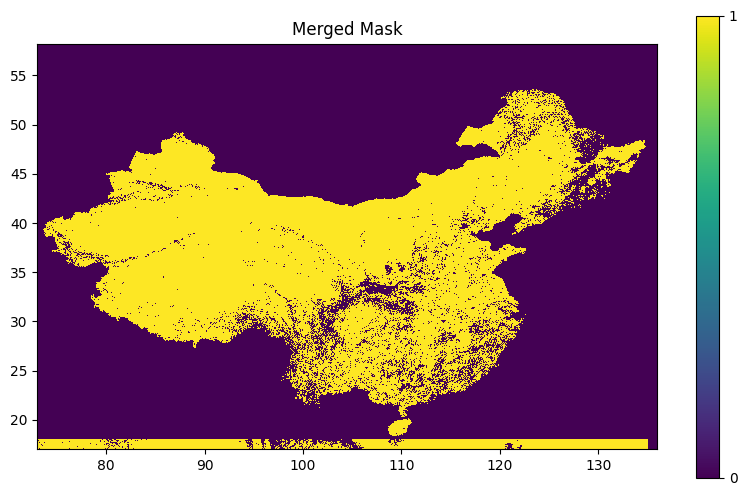

In [37]:
# merge and plot only, do not save
china.merge_layer(attribute_save=False, layers=["slope_filtered", "modis_filtered"])

In [38]:
china

Mask China: 
4 layers: ['modis_filtered', 'elevation_filtered', 'slope_filtered', 'protected'].
No merged_mask ready. 
No shape has been extracted. 
Mask has not been saved/updated. 

Try again with the `reference_layer` parameter:

In [39]:
china.merge_layer(
    layers=["elevation_filtered", "modis_filtered"],
    reference_layer="elevation_filtered",
    show_raster=False,
)

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


The result of the `merged_mask` method is saved to `china.merged_mask` with the same resolution as the reference layer, in this case `elevation_filtered`.

In [40]:
china.merged_mask.res

(0.008983152841195215, 0.008983152841195215)

For the purpose of this demonstration, we will select the AND method for the final merged_mask. We can also trim the border of the merged mask since the 4 layers have different boundaries. We can set the parameter `trim = True`.

INFO:geodata.mask:Overwriting current merged_mask.
INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


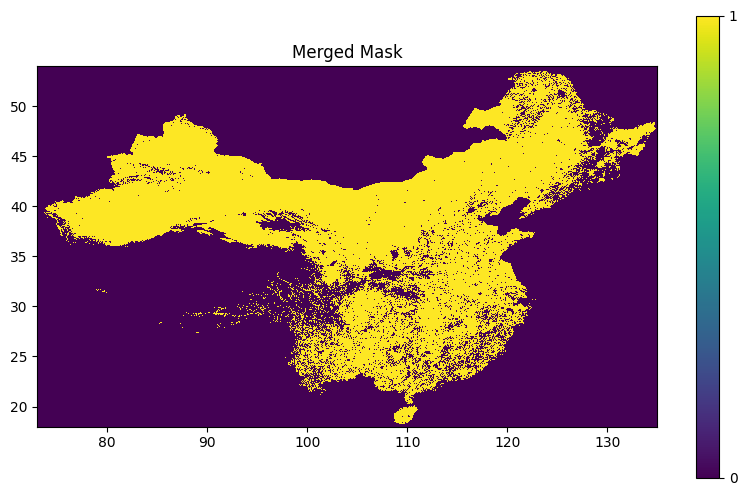

In [41]:
china.merge_layer(trim=True)

### 5.2 sum method

The sum method will add up the values from all the layers using weights. When there is no weight dict provided, all the layers for merging will have weights of 1 by default.

Note: since we are not using the sum method to proceed to the following sections, we will keep `attribute_save = False` to prevent this method from overwriting the mask we have previously created above.

INFO:geodata.mask:No weight dictionary provided, all the layers for merging will have weights of 1 by default


<open DatasetReader name='/vsimem/5c1f41bb-18e4-47c5-b90c-38a33025b697/5c1f41bb-18e4-47c5-b90c-38a33025b697.tif' mode='r'>

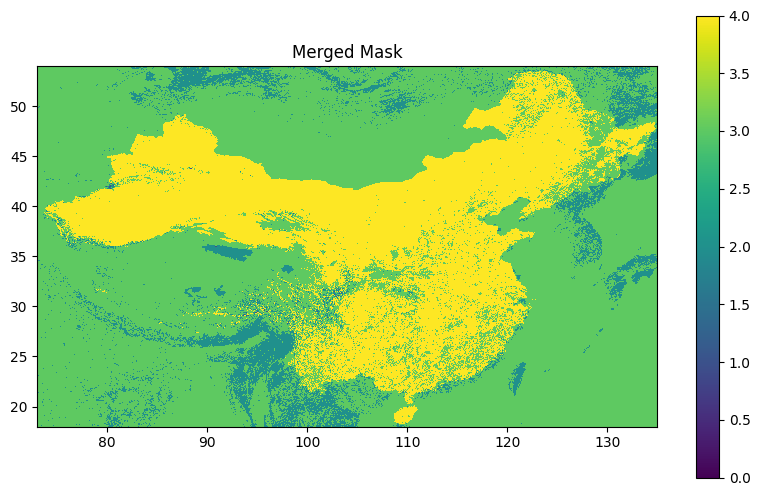

In [42]:
china.merge_layer(method="sum", attribute_save=False, trim=True)

This distribution is completely arbitrary for the purpose of demonstration of the module: (Note: The weights do not need to have a total of 1)
- elevation_filtered: 0.15, slope_filtered: 0.1, modis_filtered: 0.3, protected: 0.45

We will write the result to a new variable `customized_merged_layer` for continuing processing.

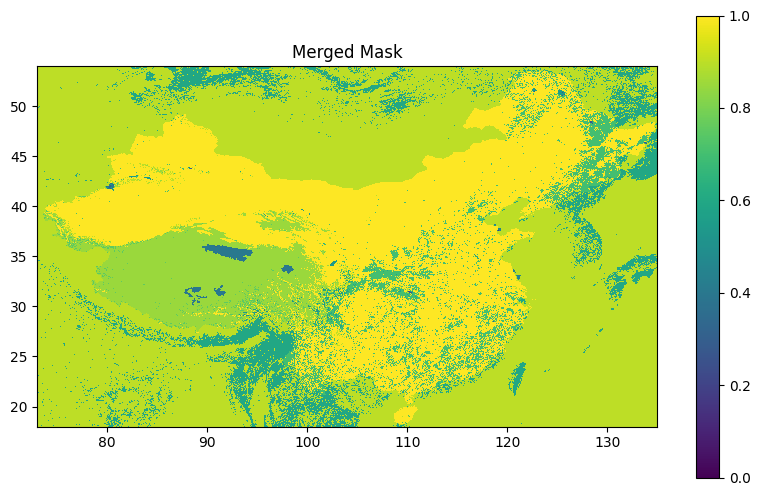

In [43]:
customized_merged_layer = china.merge_layer(
    method="sum",
    weights={
        "elevation_filtered": 0.15,
        "slope_filtered": 0.1,
        "modis_filtered": 0.3,
        "protected": 0.45,
    },
    attribute_save=False,
    trim=True,
)

If the continuous value created by `merged_mask` represents a suitability metric, we could set a minimum value of 0.8 to be considered "suitable" (or 1). We then apply the `filter_raster` method on the merged layer.

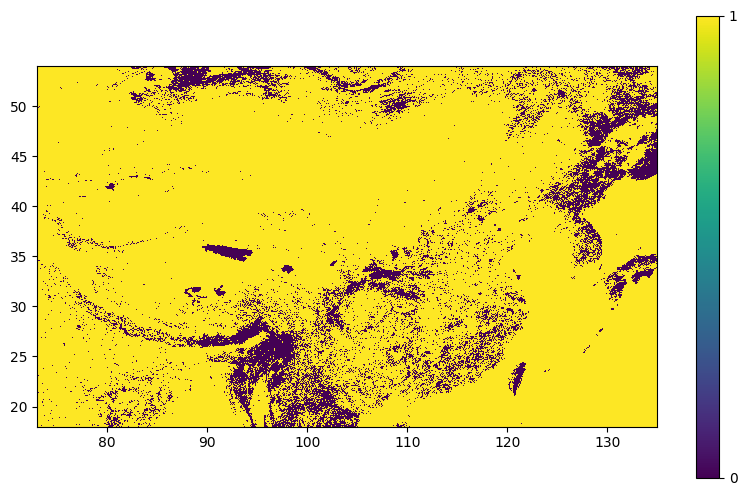

In [44]:
customized_merged_layer = geodata.mask.filter_raster(
    customized_merged_layer, min_bound=0.8, binarize=True
)
show(customized_merged_layer)

## 6. Eliminate small contiguous areas

Using the above methods, we might end up with many small contiguous areas that are marked suitable but surrounded by an unsuitable region. We may want to exclude such regions from renewable energy development. The `filter_area` method will remove the small contiguous suitable regions by transforming the merged mask raster to polygons/shapes, calculating the area of each polygon, and filtering out polygons that are smaller than a given threshold. Units are given in kilometer-squared (km$^2$).

By default, `filter_area` uses the merged mask raster and returns a new raster, unless input/output layers are specified by `layer_name` and `dest_layer_name`. 

By default, its `shape_value` parameter is 1, indicating that we are only interested in finding all groups of cells with value 1 (suitable) for elimination. We specify the threshold with the `min_area` parameter.

Note: the `filter_area` method may take a long time (5 or more minutes depending on the complexity of your layer and your computational setup). The method relies upon `rasterio.rasterize`, see performance notes: https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize


For example, if we focus on Guangdong province in Southern China from the merged mask, we notice that there are many small islands in the ocean that are marked as suitable areas. We want to exclude these small regions from our merged mask.

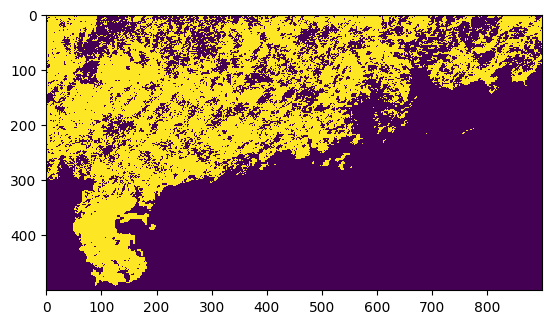

In [45]:
plt.imshow(china.merged_mask.read(1)[4800:5300, 5700:6600], interpolation="none")
plt.show()

Call `filter_area` to remove all contiguous suitable region shapes smaller than 100 km$^2$:

In [46]:
china.merged_mask = geodata.mask.filter_area(china, min_area=100)

INFO:geodata.mask:Reprojecting the raster to EPSG:6933 for equal area calculation.
INFO:geodata.mask:Raster /vsimem/11070484-d920-4519-80a7-25f47a0b2d7f/11070484-d920-4519-80a7-25f47a0b2d7f.tif has been reprojected to EPSG:6933 CRS.
INFO:geodata.mask:Reverting the remaining shapes back to a raster.


There shapes are removed in the new merged_mask.

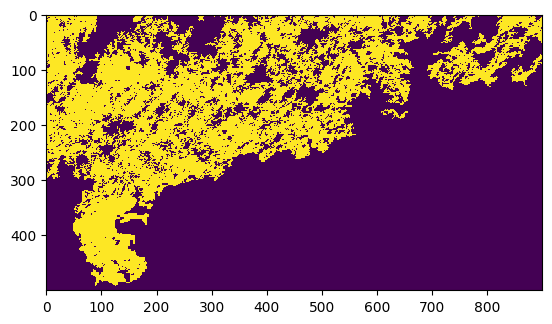

In [47]:
plt.imshow(china.merged_mask.read(1)[4800:5300, 5700:6600], interpolation="none")
plt.show()

## 7. Extracting shapes from mask

Sometimes the user needs to generate masks and perform analysis for a collection of regions (e.g., at the state/province level). The purpose of shape extraction (`extract_shapes`) is to separate `merged_mask` values for each region, with the result a dictionary of name-mask pairs in the `shape_mask` attribute of the mask object. The values of `shape_mask` will be 0 outside of the shape, and will be `merged_mask` inside of the shape.

For the purpose of this demonstration, we will only select the province of Jiangsu, Zhejiang, and Shanghai.

In [48]:
china_shapes_subset = china_shapes[
    china_shapes["name"].isin(["Jiangsu", "Zhejiang", "Shanghai"])
]
china_shapes_subset

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
2115,Admin-1 states provinces,2,CHN-1820,1820,CN-ZJ,NaN,CN,5,Zhejiang,Zhèjiāng,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((121.25553 28.14000, 121.26454 ..."
2116,Admin-1 states provinces,2,CHN-1819,1819,CN-SH,NaN,CN,5,Shanghai,Shànghǎi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((121.83774 31.37515, 121.85377 ..."
2118,Admin-1 states provinces,2,CHN-1818,1818,CN-JS,NaN,CN,3,Jiangsu,Jiāngsū,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((119.88071 32.12519, 119.90138 ..."


Converting the filtered shape dictionary to a python dictionary as the input for `extract_shapes`, where the keys for the dictionary will be the names of the new extracted shape layers.

In [49]:
china_shapes_subset = (
    china_shapes_subset[["name", "geometry"]].set_index("name")["geometry"].to_dict()
)
china_shapes_subset

{'Zhejiang': <MULTIPOLYGON (((121.256 28.14, 121.265 28.122, 121.285 28.102, 121.279 28.0...>,
 'Shanghai': <MULTIPOLYGON (((121.838 31.375, 121.854 31.373, 121.868 31.366, 121.878 31....>,
 'Jiangsu': <MULTIPOLYGON (((119.881 32.125, 119.901 32.082, 119.902 32.073, 119.89 32.0...>}

Extract the shapes from the merged_mask. 

In [50]:
china.extract_shapes(china_shapes_subset)

INFO:geodata.mask:Extracted shape Zhejiang added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Shanghai added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Jiangsu added to attribute 'shape_mask'.


The resulting mask object contains the dictionary `shape_mask` with the extracted values:

In [51]:
china

Mask China: 
4 layers: ['modis_filtered', 'elevation_filtered', 'slope_filtered', 'protected'].
Merged_mask merged/flattened. 
3 shape_mask: ['Zhejiang', 'Shanghai', 'Jiangsu']. 
Mask has not been saved/updated. 

## 8. Saving and Loading masks

In [ ]:
china.save_mask()

With the mask saved, the user can now load the layers or shapes with `xarray` instead if preferred.

INFO:geodata.mask:Please close the shape_mask xarray(s) for further changes of the mask object.


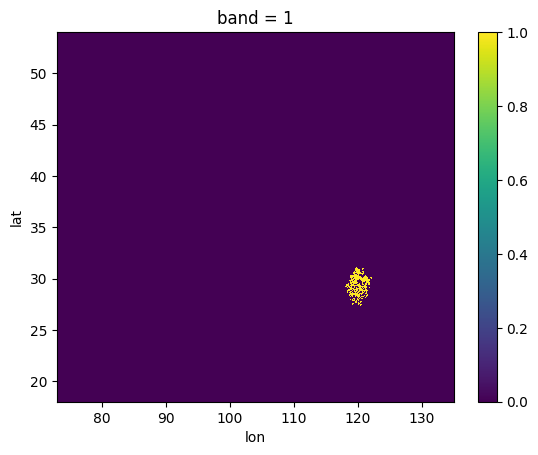

In [53]:
shape_xr_lst = china.load_shape_xr()
shape_xr_lst["Zhejiang"].plot()

Optional: closing all the files when saving the mask. This can avoid possible write permission error.

In [ ]:
china.save_mask(close_files=True)

Loading a previously saved mask.

In [55]:
china_2 = geodata.mask.load_mask("china")

INFO:geodata.mask:No previously saved mask found for mask china
INFO:geodata.mask:Layer [] loaded to the mask china.
INFO:geodata.mask:No Merged Mask found.


In [56]:
china_2

Mask china: 
0 layers: [].
No merged_mask ready. 
No shape has been extracted. 
Mask has been saved. 